# IMPORTING LIBRARIES

In [239]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm as cmaps
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import re
import seaborn as sns
from scipy import stats
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print("Packages loaded!")

Packages loaded!


# Pipeline Controller

df = load_original_data()
df_cleaned = delete_unncessary_columns(df)
df_cleaned = make_columns_lowercase(df_cleaned)
df_cleaned = delete_non_legit_XDC_IDs(df_cleaned)
df_cleaned, date_columns = date_columns_transform_into_datetime(df_cleaned)
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])
df_cleaned = substitute_familie_int_str(df_cleaned)
df_cleaned = add_date_month_string_columns(df_cleaned, date_columns)
df_cleaned = string_comma_to_dot_float(df_cleaned)
#df_cleaned = clean_personal_names(df_cleaned)

# READ DATA INTO DATAFRAME FROM EXISTING .CSV

In [240]:
def load_original_data():
    """
    Read production data and parse into pandas dataframe.
    """
    latest_file = r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\DA_Midterm_Project\_Data\Production_Data.csv"
    df_prod_whole = pd.read_csv(latest_file, sep=";", encoding = "ISO-8859-1")
    
    return df_prod_whole

df_prod_whole = load_original_data()

# DF CLEANING

## Make columns lowercase and fix syntax

In [241]:
def make_columns_lowercase(df):
    
    lower_cols = [i.lower().replace(" ", "_").replace("-", "_") for i in df.columns]
    df.columns = lower_cols    
    
    return df

df_cleaned = make_columns_lowercase(df_prod_whole)

## Remove rows with XDC-ID < `68.000`

In [242]:
def delete_rows_with_XDC_ID_pre_68k(df):
    """
    Delete all entries before XDC-ID 68.000 due to them having wrong defect IDs.
    Only applies if dataframe actually has older entries with XDC-IDs < 68.000
    """
    
    df = df[df["pdc_nummer"]>=68000]
    
    return df

df_cleaned = delete_rows_with_XDC_ID_pre_68k(df_prod_whole)

## Remove rows without entries in selected columns

In [243]:
def delete_rows_with_nan_in_selected_cols(df, cols):
    """
    Delete rows that do not have an entry in the given columns
    """
    for col in cols:
        df[col].dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
        
    return df
    
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])

## Delete unncessary/empty colums

In [244]:
def delete_unncessary_columns(df):
    """
    Delete columns only containing NaN values or columns with effectively useless data
    """
    #try:
    columns_to_drop = []    

    partial_col_strings_to_drop = ["datum", "wt1", "wt2", "ort", "geraet", "defekt", "charge",
                                  "kommentar", "offset", "uebergabe", "id", "kanal", "version",
                                  "coating", "versand", "shore", "linear", "auslenkung", "et2", "ft2",
                                  "schneiden", "schleifen", "assembl", "grenzwert", "personal"]

    for drop_col in partial_col_strings_to_drop:
        columns_to_drop.extend([col for col in df.columns if drop_col in col.lower()])

    columns_to_drop.extend(['versand_intern',
                             'ssma_timestamp',
                             'assembley_teflonschlauch_charge',
                             'pdc_nummer',
                             'dose', "ft1_typ", "ek_groesse"])
    
    df.drop(columns=columns_to_drop, inplace=True)

    #except:
        #raise ValueError("Deleting columns was unsuccessful!")
    
    return df

df_cleaned = delete_unncessary_columns(df_prod_whole)

## Drop unnecessary `Familie` type

In [245]:
def substitute_familie_int_str(df):
    """
    Only keep PDCs (1)
    """
    
    df = df[(df["familie"]==1)]
        
    return df

df_cleaned = substitute_familie_int_str(df_cleaned)

## Turn string-comma-values into dot-float-values

In [246]:
def string_comma_to_dot_float(df):
    """
    Cast string-comma-values as dot-float-values
    """
    cols_to_use = ['ns1_winkel_vorne','ns1_winkel_hinten','ns1_durchmesser_vorne','ns1_durchmesser_hinten',
               "ns2_center_variation", "ns2_front_angle","ns2_curve","ns2_15xlength",
               "ns2_parabolic_factor","oeo_oeo", "piezo_phase"] 

    for column in cols_to_use:
        df[column] = [float(str(x).replace(',','.')) for x in df[column]] 
     
    return df

df_cleaned = string_comma_to_dot_float(df_cleaned)

## Clean personal (operator) initials

In [247]:
def clean_personal_names(df):
    """
    Func descr
    """
    
    replacements = {'GD': 'GDH',
                    'MFW': 'MFE',
                    "ME": "MFE",
                    "MF": "MFE",
                    "LAE": "AL",
                    "SF": "SFZ",
                    "DC": "AC",
                    "THANH": "TT",
                    "?": np.nan}
    
    personal_cols = [col for col in df_cleaned.columns if "personal" in col]
    
    for col in personal_cols:
        op_list = []

        for op in df_cleaned["ft1_personal"]:
            if type(op)==str and op.isalpha():
                op_list.append(op.upper())
            elif op=="?":
                op_list.append(np.nan)
            elif type(op)==str and "." in op:
                op_list.append(np.nan)
            elif type(op)==str and not op.isalpha() and op!="?":
                op_list.append(op[:re.search(r'\W+', op).start()].upper())
            else:
                op_list.append(np.nan)

        op_list = [replacements.get(word, word) for word in op_list]

        df[col] = op_list
        
    return df
    
#df_cleaned = clean_personal_names(df_cleaned)

In [248]:
df_cleaned.columns

Index(['produktion_groesse', 'familie', 'art', 'ns1_winkel_vorne',
       'ns1_winkel_hinten', 'ns1_durchmesser_vorne', 'ns1_durchmesser_hinten',
       'ns2_center_variation', 'ns2_front_angle', 'ns2_curve', 'ns2_15xlength',
       'ns2_parabolic_factor', 'oeo_oeo', 'kleben1_kleber_teilentnahme',
       'kleben2_kleber_teilentnahme', 'bqc_spannung', 'bqc_puls',
       'bqc_volumen', 'et1_spannung', 'et1_puls', 'et1_volumen',
       'ft1_spannung', 'ft1_puls', 'ft1_volumen', 'ek_spannung', 'ek_puls',
       'ek_volumen', 'piezo_position', 'piezo_phase'],
      dtype='object')

def clean_personal_names(df):
    """
    Func descr
    """

    ### UPDATE DATAFRAME OPERATORS WITH CAPITALIZATION & SINGLE-OP ###
    Schmelzen_OP_List = list(df["schmelzen_personal"])
    #Schneiden_OP_List = list(df["schneiden_personal"])
    NS1_OP_List = list(df["ns1_personal"])
    #Schleifen_OP_List = list(df["schleifen_personal"])
    NS2_OP_List = list(df["ns2_personal"])
    OeO_OP_List = list(df["oeo_personal"])
    K1_OP_List = list(df["kleben1_personal"])
    K2_OP_List = list(df["kleben2_personal"])
    #Ass_OP_List = list(df["assembley_personal"])
    BQC_OP_List = list(df["bqc_personal"])
    ET_OP_List = list(df["et1_personal"])
    FT_OP_List = list(df["ft1_personal"])
    EK_OP_List = list(df["ek_personal"])
    
    for schmop in range(len(Schmelzen_OP_List)):
        if Schmelzen_OP_List[schmop] == 0 or type(Schmelzen_OP_List[schmop])==float:
            pass
        elif Schmelzen_OP_List[schmop].isupper():
            Schmelzen_OP_List[schmop] = Schmelzen_OP_List[schmop][:2]
        elif not Schmelzen_OP_List[schmop].isupper():
            Schmelzen_OP_List[schmop] = Schmelzen_OP_List[schmop][:2].upper()

    #for schnop in range(len(Schneiden_OP_List)):
        #if Schneiden_OP_List[schnop] == 0 or type(Schneiden_OP_List[schnop])==float:
            #pass
        #elif Schneiden_OP_List[schnop].isupper():
            #Schneiden_OP_List[schnop] = Schneiden_OP_List[schnop][:2]
        #elif not Schneiden_OP_List[schnop].isupper():
            #Schneiden_OP_List[schnop] = Schneiden_OP_List[schnop][:2].upper()

    for ns1op in range(len(NS1_OP_List)):
        if NS1_OP_List[ns1op] == 0 or type(NS1_OP_List[ns1op])==float:
            pass
        elif NS1_OP_List[ns1op].isupper():
            NS1_OP_List[ns1op] = NS1_OP_List[ns1op][:2]
        elif not NS1_OP_List[ns1op].isupper():
            NS1_OP_List[ns1op] = NS1_OP_List[ns1op][:2].upper()

    for ns2op in range(len(NS2_OP_List)):
        if NS2_OP_List[ns2op] == 0 or type(NS2_OP_List[ns2op])==float:
            pass
        elif NS2_OP_List[ns2op].isupper():
            NS2_OP_List[ns2op] = NS2_OP_List[ns2op][:2]
        elif not NS2_OP_List[ns2op].isupper():
            NS2_OP_List[ns2op] = NS2_OP_List[ns2op][:2].upper()

    for oeoop in range(len(OeO_OP_List)):
        if OeO_OP_List[oeoop] == 0 or type(OeO_OP_List[oeoop])==float:
            pass
        elif OeO_OP_List[oeoop].isupper():
            OeO_OP_List[oeoop] = OeO_OP_List[oeoop][:2]
        elif not OeO_OP_List[oeoop].isupper():
            OeO_OP_List[oeoop] = OeO_OP_List[oeoop][:2].upper()

    for k1op in range(len(K1_OP_List)):
        if K1_OP_List[k1op] == 0 or type(K1_OP_List[k1op])==float:
            pass
        elif K1_OP_List[k1op].isupper():
            K1_OP_List[k1op] = K1_OP_List[k1op][:2]
        elif not K1_OP_List[k1op].isupper():
            K1_OP_List[k1op] = K1_OP_List[k1op][:2].upper()

    for k2op in range(len(K2_OP_List)):
        if K2_OP_List[k2op] == 0 or type(K2_OP_List[k2op])==float:
            pass
        elif K2_OP_List[k2op].isupper():
            K2_OP_List[k2op] = K2_OP_List[k2op][:2]
        elif not K2_OP_List[k2op].isupper():
            K2_OP_List[k2op] = K2_OP_List[k2op][:2].upper()

    #for assop in range(len(Ass_OP_List)):
        #if Ass_OP_List[assop] == 0 or type(Ass_OP_List[assop])==float:
            #pass
        #elif Ass_OP_List[assop].isupper():
            #Ass_OP_List[assop] = Ass_OP_List[assop][:2]
        #elif not Ass_OP_List[assop].isupper():
            #Ass_OP_List[assop] = Ass_OP_List[assop][:2].upper()

    for bqcop in range(len(BQC_OP_List)):
        if BQC_OP_List[bqcop] == 0 or type(BQC_OP_List[bqcop])==float:
            pass
        elif BQC_OP_List[bqcop].isupper():
            BQC_OP_List[bqcop] = BQC_OP_List[bqcop][:3]
        elif not BQC_OP_List[bqcop].isupper():
            BQC_OP_List[bqcop] = BQC_OP_List[bqcop][:3].upper()

    for etop in range(len(ET_OP_List)):
        if ET_OP_List[etop] == "MF":
            ET_OP_List[etop]=="MFE"
        if ET_OP_List[etop] == 0 or type(ET_OP_List[etop])==float:
            pass
        elif ET_OP_List[etop].isupper():
            ET_OP_List[etop] = ET_OP_List[etop][:3]
        elif not ET_OP_List[etop].isupper():
            ET_OP_List[etop] = ET_OP_List[etop][:3].upper()
        if type(ET_OP_List[etop])!=float:
            ET_OP_List[etop] = re.sub(r'[^\w]', '', ET_OP_List[etop])
            ET_OP_List[etop] = ''.join(i for i in ET_OP_List[etop] if not i.isdigit())

    FT_OP_List_ = []
    for ftop in range(len(FT_OP_List)):
        if FT_OP_List[ftop] == "MF":
            FT_OP_List_.append("MFE")
        elif FT_OP_List[ftop] == "SC_":
            FT_OP_List_.append("SC")
        elif FT_OP_List[ftop] == 0 or type(FT_OP_List[ftop])==float:
            FT_OP_List_.append(np.nan)
        elif FT_OP_List[ftop].isupper():
            FT_OP_List_.append(FT_OP_List[ftop][:3])
        elif not FT_OP_List[ftop].isupper():
            FT_OP_List_.append(FT_OP_List[ftop][:3].upper())
        elif type(FT_OP_List[ftop])!=float:
            FT_OP_List_.append(re.sub(r'[^\w]', '', FT_OP_List[ftop]))
            FT_OP_List_.append(''.join(i for i in FT_OP_List[ftop] if not i.isdigit()))

    for ekop in range(len(EK_OP_List)):
        if EK_OP_List[ekop] == "MF":
            EK_OP_List[ekop]=="MFE"
        if EK_OP_List[ekop] == 0 or type(EK_OP_List[ekop])==float:
            pass
        elif EK_OP_List[ekop].isupper():
            EK_OP_List[ekop] = EK_OP_List[ekop][:3]
        elif not EK_OP_List[ekop].isupper():
            EK_OP_List[ekop] = EK_OP_List[ekop][:3].upper()
        if type(EK_OP_List[ekop])!=float:
            EK_OP_List[ekop] = re.sub(r'[^\w]', '', EK_OP_List[ekop])
            EK_OP_List[ekop] = ''.join(i for i in EK_OP_List[ekop] if not i.isdigit())
            
    df["schmelzen_personal"] = Schmelzen_OP_List
    #df["schneiden_personal"] = Schneiden_OP_List
    df["ns1_personal"] = NS1_OP_List
    df["ns2_personal"] = NS2_OP_List
    df["oeo_personal"] = OeO_OP_List
    df["kleben1_personal"] = K1_OP_List
    df["kleben2_personal"] = K2_OP_List
    #df["assembley_personal"] = Ass_OP_List
    df["bqc_personal"] = BQC_OP_List
    df["et1_personal"] = ET_OP_List
    df["ft1_personal"] = FT_OP_List
    df["ek_personal"] = EK_OP_List
    
    return df
    
df_cleaned = clean_personal_names(df_cleaned)

## Rename different QC columns to generic form

In [249]:
def rename_qc_columns(df):
    """
    Func descr
    """
    
    df.rename(columns={'bqc_volumen': 'qc1_volumen', 
                                     'et1_volumen': 'qc2_volumen',
                                    'ft1_volumen': 'qc3_volumen',
                                    'ek_volumen': 'qc4_volumen',

                                    'bqc_spannung': 'qc1_spannung', 
                                     'et1_spannung': 'qc2_spannung',
                                    'ft1_spannung': 'qc3_spannung',
                                    'ek_spannung': 'qc4_spannung',

                                    'bqc_puls': 'qc1_puls', 
                                     'et1_puls': 'qc2_puls',
                                    'ft1_puls': 'qc3_puls',
                                    'ek_puls': 'qc4_puls'}, inplace=True)
    
    return df

df_cleaned = rename_qc_columns(df_cleaned)

# PROCESSING `NUMERICAL` AND `CATEGORICAL` DATA

In [250]:
# AVG ALL QC_VOLUMEs TO YIELD SINGLE TARGET FEATURE
qc1_vol = df_cleaned["qc1_volumen"]
qc2_vol = df_cleaned["qc2_volumen"]
qc3_vol = df_cleaned["qc3_volumen"]
qc4_vol = df_cleaned["qc4_volumen"]

qc1_voltage = df_cleaned["qc1_spannung"]
qc2_voltage = df_cleaned["qc2_spannung"]
qc3_voltage = df_cleaned["qc3_spannung"]
qc4_voltage = df_cleaned["qc4_spannung"]

qc1_pulse = df_cleaned["qc1_puls"]
qc2_pulse = df_cleaned["qc2_puls"]
qc3_pulse = df_cleaned["qc3_puls"]
qc4_pulse = df_cleaned["qc4_puls"]

qc_volumes = list(zip(qc1_vol, qc2_vol, qc3_vol, qc4_vol))
qc_voltages = list(zip(qc1_voltage, qc2_voltage, qc3_voltage, qc4_voltage))
qc_pulses = list(zip(qc1_pulse, qc2_pulse, qc3_pulse, qc4_pulse))

qc_volume_means = [np.nanmean(volume) for volume in qc_volumes]
qc_voltage_means = [np.nanmean(voltage) for voltage in qc_voltages]
qc_puls_means = [np.nanmean(puls) for puls in qc_pulses]

# ADD NEW QC_MEAN COLUMNS TO DF
df_cleaned["qc_volume_mean"] = qc_volume_means
df_cleaned["qc_voltage_mean"] = qc_voltage_means
df_cleaned["qc_puls_mean"] = qc_puls_means

# DROP SPECIFIC QC VOLUME, VOLTAGE, PULS COLUMNS & ONLY KEEP AVERAGED COLS
df_cleaned.drop(columns=["qc1_volumen", "qc2_volumen", "qc3_volumen","qc4_volumen",
                        "qc1_spannung","qc2_spannung","qc3_spannung","qc4_spannung",
                        "qc1_puls","qc2_puls","qc3_puls","qc4_puls"], inplace=True)

# DROP ROWS WHERE QC VOLUME, VOLTAGE, PULSE IS BELOW/ABOVE CRITICAL, SENSIBLE THRESHOLD
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns1_durchmesser_vorne"]>0) &
                       (df_cleaned["ns1_durchmesser_vorne"]<=100)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns1_durchmesser_hinten"]>0) &
                       (df_cleaned["ns1_durchmesser_hinten"]<=90)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns2_15xlength"]>0) &
                       (df_cleaned["ns2_15xlength"]<=7)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns2_parabolic_factor"]>=29) &
                       (df_cleaned["ns2_parabolic_factor"]<=37)]
print(len(df_cleaned))
#df_cleaned = df_cleaned[(df_cleaned["ns2_center_variation"]>=0) &
                       #(df_cleaned["ns2_center_variation"]<=1.4)]
#print(len(df_cleaned))
#df_cleaned = df_cleaned[(df_cleaned["ns2_front_angle"]>0) &
                       #(df_cleaned["ns2_front_angle"]<=1.2)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["oeo_oeo"]>=30) &
                       (df_cleaned["oeo_oeo"]<=70)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_volume_mean"]>=150) &
                       (df_cleaned["qc_volume_mean"]<=650)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_voltage_mean"]>=50) &
                       (df_cleaned["qc_voltage_mean"]<=170)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_puls_mean"]>=40) &
                       (df_cleaned["qc_puls_mean"]<=55)].reset_index(drop=True)
print(len(df_cleaned))

104702
103175
103101
55270
53508
53508
38005
28227
27629
27263


## Processing NaN values - Numericals

### Fill NaN piezo_phase values with column mean

In [216]:
df_numerical["piezo_phase"].fillna(int(df_numerical["piezo_phase"].mean()), inplace=True)

KeyError: 'piezo_phase'

### Fill NaN ns1 values with column mean

In [ ]:
num_cols_to_use_for_fillna_mean = ['ns1_winkel_vorne', 'ns1_winkel_hinten', 'ns1_durchmesser_vorne',
       'ns1_durchmesser_hinten', 'ns2_center_variation', 'ns2_front_angle',
       'ns2_curve', 'ns2_15xlength', 'piezo_phase',
       'oeo_oeo']

for num_col in num_cols_to_use_for_fillna_mean:
    df_numerical[num_col].fillna(np.nanmedian(df_numerical[num_col]), inplace=True)

In [ ]:
df_numerical["ns1_winkel_vorne"].fillna(np.nanmean(df_numerical["ns1_winkel_vorne"]), inplace=True)
df_numerical["ns1_winkel_hinten"].fillna(np.nanmean(df_numerical["ns1_winkel_hinten"]), inplace=True)
df_numerical["ns1_durchmesser_vorne"].fillna(np.nanmean(df_numerical["ns1_durchmesser_vorne"]), inplace=True)
df_numerical["ns1_durchmesser_hinten"].fillna(np.nanmean(df_numerical["ns1_durchmesser_hinten"]), inplace=True)

## Processing NaN values - Categoricals

### Fill NaN values with mode in respective personal columns

In [ ]:
# Get all columns containing "personal"
pers_cols = [col for col in df_categorical.columns if "personal" in col]

for col in pers_cols:
    mode = stats.mode(df_categorical[col])[0][0]
    df_categorical[col].fillna(mode, inplace=True)

### Fill missing place with P distribution, where 67% of the time the product comes from Berlin

In [ ]:
df_categorical["schmelzen_ort"].fillna(random.choices(['Berlin', 'Dortmund'], 
                                                      weights=[0.67, 0.33], k=1)[0], inplace=True)

### Fill NaN values of produktion_groesse with static value 1

In [ ]:
df_categorical["produktion_groesse"].fillna(1, inplace=True)

### Fill NaN kleben1_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 5 --> based on procedural limits*

In [ ]:
df_categorical["kleben1_kleber_teilentnahme"].fillna(int(np.mean(
    [int(k1e) for k1e in list(df_categorical["kleben1_kleber_teilentnahme"].unique()) if 6 > k1e > 0])), inplace=True)

### Fill NaN kleben2_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 6 --> based on procedural limits*

In [ ]:
df_categorical["kleben2_kleber_teilentnahme"].fillna(
    int(np.mean([int(k1e) for k1e in list(df_categorical["kleben2_kleber_teilentnahme"].unique()) if 7 > k1e > 0])), inplace=True)

### Fill NaN piezo_phase with average of non-zero entries

In [ ]:
df_complete = pd.concat([df_numerical, df_categorical], axis=1)

df_complete_QC1 = df_complete[df_complete["qc1_volumen"].notnull()].reset_index(drop=True)
df_complete_QC2 = df_complete[df_complete["qc2_volumen"].notnull()].reset_index(drop=True)
df_complete_QC3 = df_complete[df_complete["qc3_volumen"].notnull()].reset_index(drop=True)
df_complete_QC4 = df_complete[df_complete["qc4_volumen"].notnull()].reset_index(drop=True)

df_complete_QC1.drop(columns=['qc2_spannung', 'qc3_spannung','qc4_spannung',
                              'qc2_puls', 'qc3_puls', 'qc4_puls',
                             'qc2_volumen', 'qc3_volumen', 'qc4_volumen'], inplace=True)

In [ ]:
numerical_cols_to_exclude = ['qc2_spannung', 'qc3_spannung','qc4_spannung',
                              'qc2_puls', 'qc3_puls', 'qc4_puls',
                             'qc2_volumen', 'qc3_volumen', 'qc4_volumen'
                            "ns2_15xlength"]
numerical_cols_to_include = [col for col in df_complete_QC1.columns if col not in numerical_cols_to_exclude]

df_complete_QC1_numerical =df_complete_QC1[numerical_cols_to_include]
df_complete_QC1_categorical = df_complete_QC1[df_categorical.columns]

## Splitting numerical and categorical data

In [237]:
def get_numerical(df):
    
    df_edanum = df_cleaned.select_dtypes(include=np.number)

    ns1_cols = [col for col in df_edanum.columns if "ns1" in col if 'geraet' not in col]
    ns2_cols = [col for col in df_edanum.columns if "ns2" in col if 'geraet' not in col]
    piezo_cols = [col for col in df_edanum.columns if "piezo" in col]
    oeo_cols=[col for col in df_edanum.columns if "oeo" in col]
    vol_cols = [col for col in df_edanum.columns if "volume" in col]
    span_cols =[col for col in df_edanum.columns if "spannung" in col]
    pulse_col = [col for col in df_edanum.columns if "puls" in col]

    columns_to_use = ns1_cols + ns2_cols + piezo_cols + oeo_cols + span_cols + pulse_col + vol_cols

    df_numerical = df_edanum[columns_to_use]
    
    df_numerical.rename(columns={'bqc_volumen': 'qc1_volumen', 
                                 'et1_volumen': 'qc2_volumen',
                                'ft1_volumen': 'qc3_volumen',
                                'ek_volumen': 'qc4_volumen',
                                 
                                'bqc_spannung': 'qc1_spannung', 
                                 'et1_spannung': 'qc2_spannung',
                                'ft1_spannung': 'qc3_spannung',
                                'ek_spannung': 'qc4_spannung',
                                 
                                'bqc_puls': 'qc1_puls', 
                                 'et1_puls': 'qc2_puls',
                                'ft1_puls': 'qc3_puls',
                                'ek_puls': 'qc4_puls'}, inplace=True)
    
    return df_numerical

def get_categorical(df):
    df_categorical = df_cleaned.select_dtypes(include=['object'])
    
    cols_categorical = ["familie", 
                        'schmelzen_personal', "schmelzen_ort", 
                        'ns1_personal', 'schneiden_personal', 'schleifen_personal',
                        'ns2_personal', 'oeo_personal', 
                        'kleben1_personal', 'kleben2_personal',
                        'bqc_personal', 'et1_personal', 'ft1_personal', 'ek_personal']
    
    df_categorical = df_categorical[cols_categorical]
    
    df_categorical["produktion_groesse"] = df_cleaned["produktion_groesse"]
    df_categorical["art"] = df_cleaned["art"]
    df_categorical["kleben1_kleber_teilentnahme"] = df_cleaned["kleben1_kleber_teilentnahme"]
    df_categorical["kleben2_kleber_teilentnahme"] = df_cleaned["kleben2_kleber_teilentnahme"]

    return df_categorical

#df_numerical = get_numerical(df_cleaned)
#df_categorical = get_categorical(df_cleaned)

In [251]:
# GET NUMERICAL FEATURES FROM DATAFRAME
df_numerical = df_cleaned.select_dtypes(include=np.number)

# DROP CATEGORICAL FEATURES FROM NUMERICAL DATAFRAME
df_numerical.drop(columns=["produktion_groesse", "piezo_phase", "art", "familie",
                          "kleben1_kleber_teilentnahme",
                          "kleben2_kleber_teilentnahme"], inplace=True)

In [163]:
df_numerical.describe()

ns1_winkel_vorne  ns1_winkel_hinten  ns1_durchmesser_vorne  \
count           8530.00            8530.00                8530.00   
mean              14.44              19.20                  68.08   
std               10.38              14.77                   6.14   
min                0.00               0.00                  42.00   
25%                6.00               7.00                  65.70   
50%               12.00              16.00                  68.60   
75%               22.00              28.00                  71.40   
max               40.00              70.00                  89.50   

       ns1_durchmesser_hinten  ns2_center_variation  ns2_front_angle  \
count                 8530.00               8530.00          8530.00   
mean                    60.26                  0.48             0.59   
std                      4.79                  0.34             0.26   
min                     40.70                  0.00             0.01   
25%                     57.80                  0.21             0.38   
50%                     60.50                  0.42             0.58   
75%                     63.20                  0.69             0.79   
max                     75.00                  1.72             1.19   

       ns2_curve  ns2_15xlength  ns2_parabolic_factor  oeo_oeo  \
count    8530.00        8530.00               8530.00  8530.00   
mean        1.36           5.73                 32.11    50.68   
std         0.08           0.34                  1.37     4.30   
min         0.50           4.30                 29.00    31.32   
25%         1.30           5.53                 31.10    48.97   
50%         1.40           5.77                 32.10    51.04   
75%         1.40           5.96                 33.10    53.04   
max         1.40           6.99                 36.50    66.47   

       qc_volume_mean  qc_voltage_mean  qc_puls_mean  
count         8530.00          8530.00       8530.00  
mean           383.58            85.15         48.49  
std             54.38            14.56          0.99  
min            157.00            56.00         44.50  
25%            361.00            75.50         48.00  
50%            386.50            81.00         48.50  
75%            411.25            91.00         49.00  
max            629.00           165.00         55.00

# ELIMINATE OUTLIERS BY FILTERING DATA THROUGH RESPECTIVE MIN/MAX THRESHOLDS FOR FEATURE

num_feature_min_limits = [40, 39, 0, 0, 19, 30, 150, 50, 40]
num_feature_max_limits = [100, 90, 1.4, 1.2, 37, 70, 650, 170, 55]
num_feature_to_limit = ["ns1_durchmesser_vorne", "ns1_durchmesser_hinten",
                        "ns2_front_angle", "ns2_curve", "ns2_parabolic_factor",
                        "oeo_oeo",
                        "qc_volume_mean", "qc_voltage_mean", "qc_puls_mean"]

for col in range(len(num_feature_to_limit)):
    df_numerical = df_numerical[(df_numerical[num_feature_to_limit[col]] >= num_feature_min_limits[col]) &
                               (df_numerical[num_feature_to_limit[col]] <= num_feature_max_limits[col])]\
    .reset_index(drop=True)

In [125]:
#df_numerical["ns1_durchmesser_vorne"].describe() # min 0.0
#df_numerical["ns1_durchmesser_hinten"].describe() # min 0.0
#df_numerical["ns2_front_angle"].describe() # max 3.1
#df_numerical["ns2_curve"].describe() # max 8.3
#df_numerical["ns2_parabolic_factor"].describe() # max 87
#df_numerical["oeo_oeo"].describe() # min 0.0
df_numerical["qc_volume_mean"].describe(),\
df_numerical["qc_voltage_mean"].describe(),\
df_numerical["qc_puls_mean"].describe()

(count   27381.00
 mean      375.80
 std        53.38
 min       152.00
 25%       351.00
 50%       379.25
 75%       404.33
 max       629.00
 Name: qc_volume_mean, dtype: float64,
 count   27381.00
 mean       85.57
 std        13.92
 min        50.25
 25%        76.25
 50%        82.00
 75%        91.00
 max       170.00
 Name: qc_voltage_mean, dtype: float64,
 count   27381.00
 mean       48.31
 std         1.10
 min        40.00
 25%        47.75
 50%        48.25
 75%        49.00
 max        55.00
 Name: qc_puls_mean, dtype: float64)

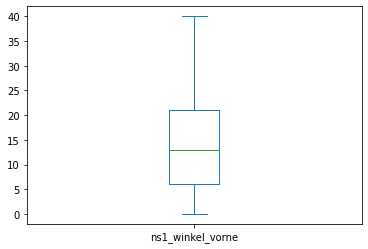

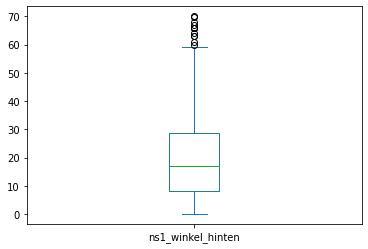

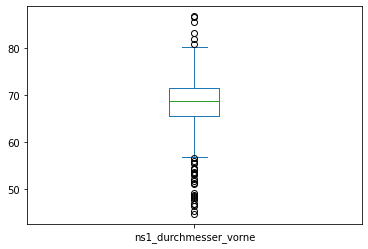

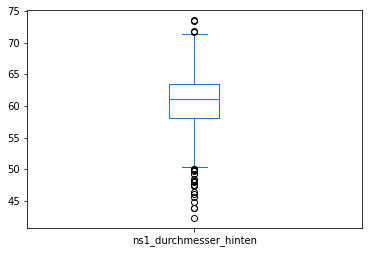

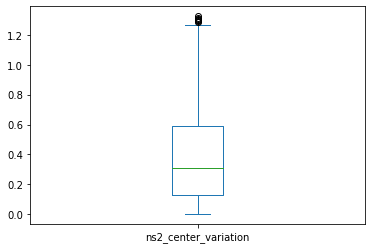

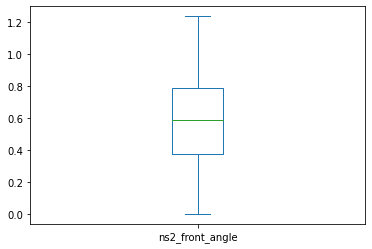

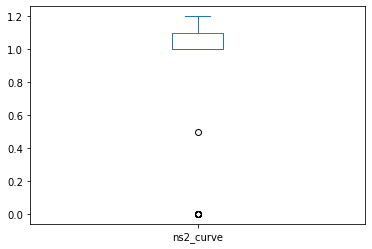

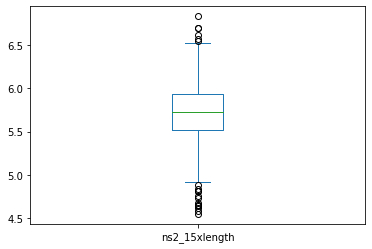

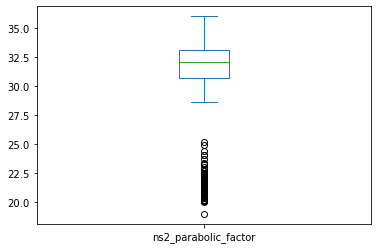

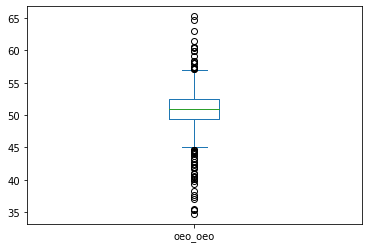

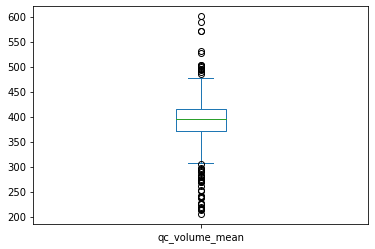

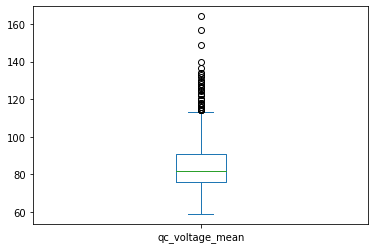

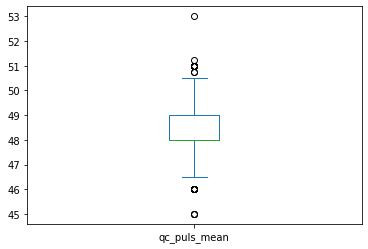

In [331]:
# CHECK OUTLIERS IN NUMERICAL DATAFRAME
for col in df_numerical.columns:
    df_numerical[col].plot.box()
    plt.show()

## Check multicollinearity for numerical features

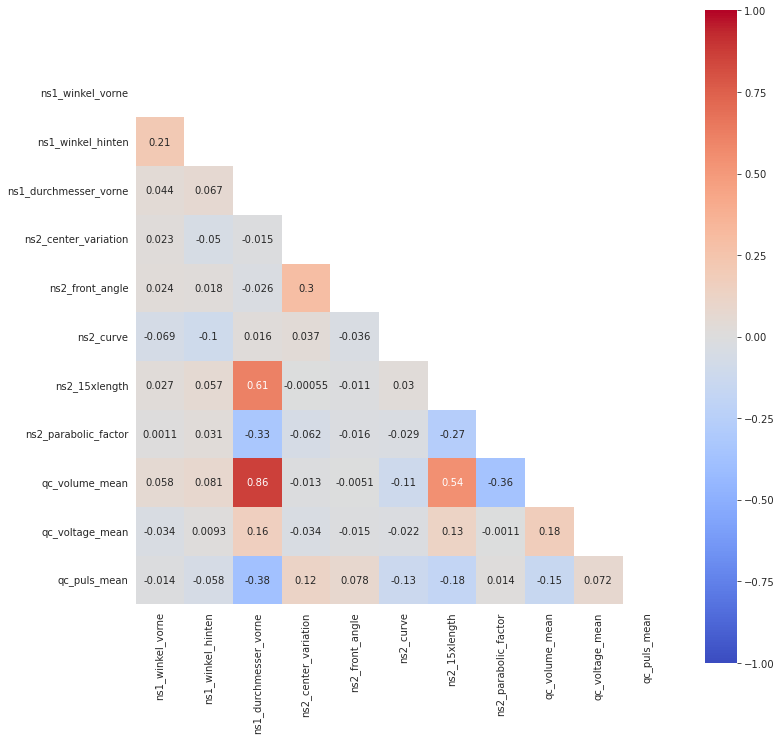

In [264]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [265]:
def show_corr_higher_threshold(df, threshold):
    """
    Show any features that have correlation higher than threshold with any other;
    """
    corr_matrix=df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    
    cols_above_threshold = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    cols_above_threshold = [col for col in cols_above_threshold if "volume" not in col]
    df = df.drop(columns=cols_above_threshold)
    return df

df_numerical = show_corr_higher_threshold(df_numerical, 0.8)

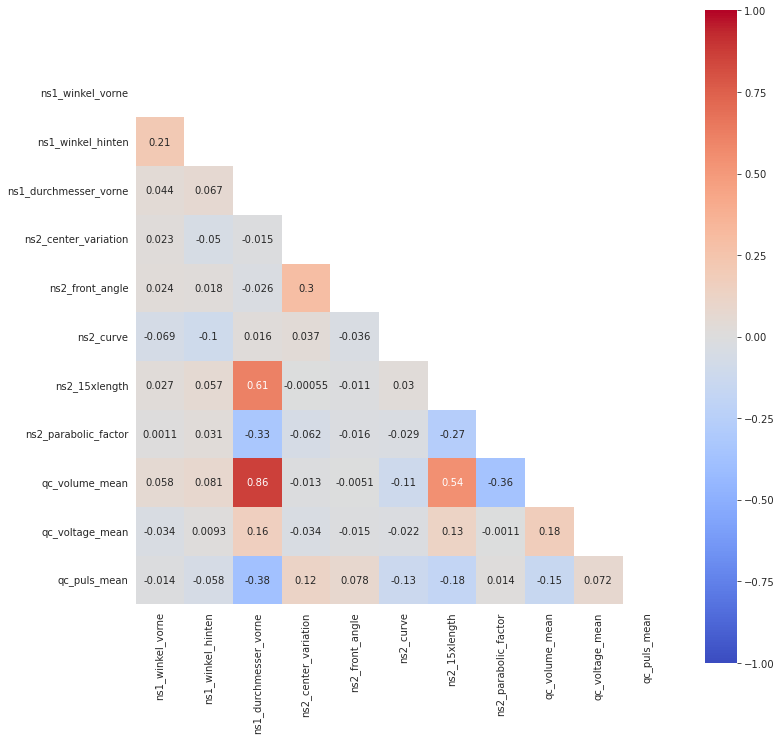

In [266]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Hot-Encode categorical features

In [33]:
#df_complete_BQC_categorical_hotcoded = pd.get_dummies(df_complete_BQC_categorical, drop_first=True)

df_categorical_hotcoded = pd.get_dummies(df_categorical, drop_first=True)


produktion_groesse  art  kleben1_kleber_teilentnahme  \
0                     1.00    1                         0.00   
1                     1.00    1                         0.00   
2                     1.00    1                         0.00   
3                     1.00    1                         0.00   
4                     1.00    1                         0.00   
...                    ...  ...                          ...   
112967                1.00    7                         3.00   
112968                1.00    7                         3.00   
112969                1.00    7                         3.00   
112970                1.00    7                         3.00   
112971                1.00    7                         3.00   

        kleben2_kleber_teilentnahme  familie_pdc-c  familie_xdc  \
0                              0.00              0            0   
1                              0.00              0            0   
2                              0.00              0            0   
3                              0.00              0            0   
4                              0.00              0            0   
...                             ...            ...          ...   
112967                         3.00              0            0   
112968                         3.00              0            0   
112969                         3.00              0            0   
112970                         3.00              0            0   
112971                         3.00              0            0   

        schmelzen_personal_AH  schmelzen_personal_AK  schmelzen_personal_AL  \
0                           0                      0                      0   
1                           0                      0                      0   
2                           0                      0                      0   
3                           0                      0                      0   
4                           0                      0                      0   
...                       ...                    ...                    ...   
112967                      0                      0                      0   
112968                      0                      0                      0   
112969                      0                      0                      0   
112970                      0                      0                      0   
112971                      0                      0                      0   

        schmelzen_personal_AL/ WH  schmelzen_personal_AL/CK  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   
...                           ...                       ...   
112967                          0                         0   
112968                          0                         0   
112969                          0                         0   
112970                          0                         0   
112971                          0                         0   

        schmelzen_personal_AL/EF  schmelzen_personal_AL/FD  \
0                              0                         0   
1                              0                         0   
2                              0                         0   
3                              0                         0   
4                              0                         0   
...                          ...                       ...   
112967                         0                         0   
112968                         0                         0   
112969                         0                         0   
112970                         0                         0   
112971                         0              

# Linear Regression

In [50]:
#df_numerical.drop(columns=['qc2_spannung', 'qc3_spannung','qc4_spannung',
                              #'qc2_puls', 'qc3_puls', 'qc4_puls',
                     #'qc2_volumen', 'qc3_volumen', 'qc4_volumen'], inplace=True)

#df_numerical = df_numerical[df_numerical["qc1_volumen"]>0].reset_index(drop=True)

#df_numerical.dropna(axis=0, inplace=True)

In [55]:
df_numerical_categorical = pd.concat((df_categorical_hotcoded, df_numerical), axis=1)

df_numerical_categorical = df_numerical_categorical[df_numerical_categorical["qc_vol_mean"]>0].reset_index(drop=True)

#df_numerical_categorical.dropna(axis=0, inplace=True)

## X-y Split (`y` is the target variable, which is the `total claim amount`)

In [267]:
#df_to_use = df_numerical_complete_BQC_categorical
print("Rows before dropping NaN values: ", len(df_numerical))
df_to_use = df_numerical.dropna(axis=0)
print("Rows after dropping NaN values: ", len(df_to_use))

Rows before dropping NaN values:  27263
Rows after dropping NaN values:  27263


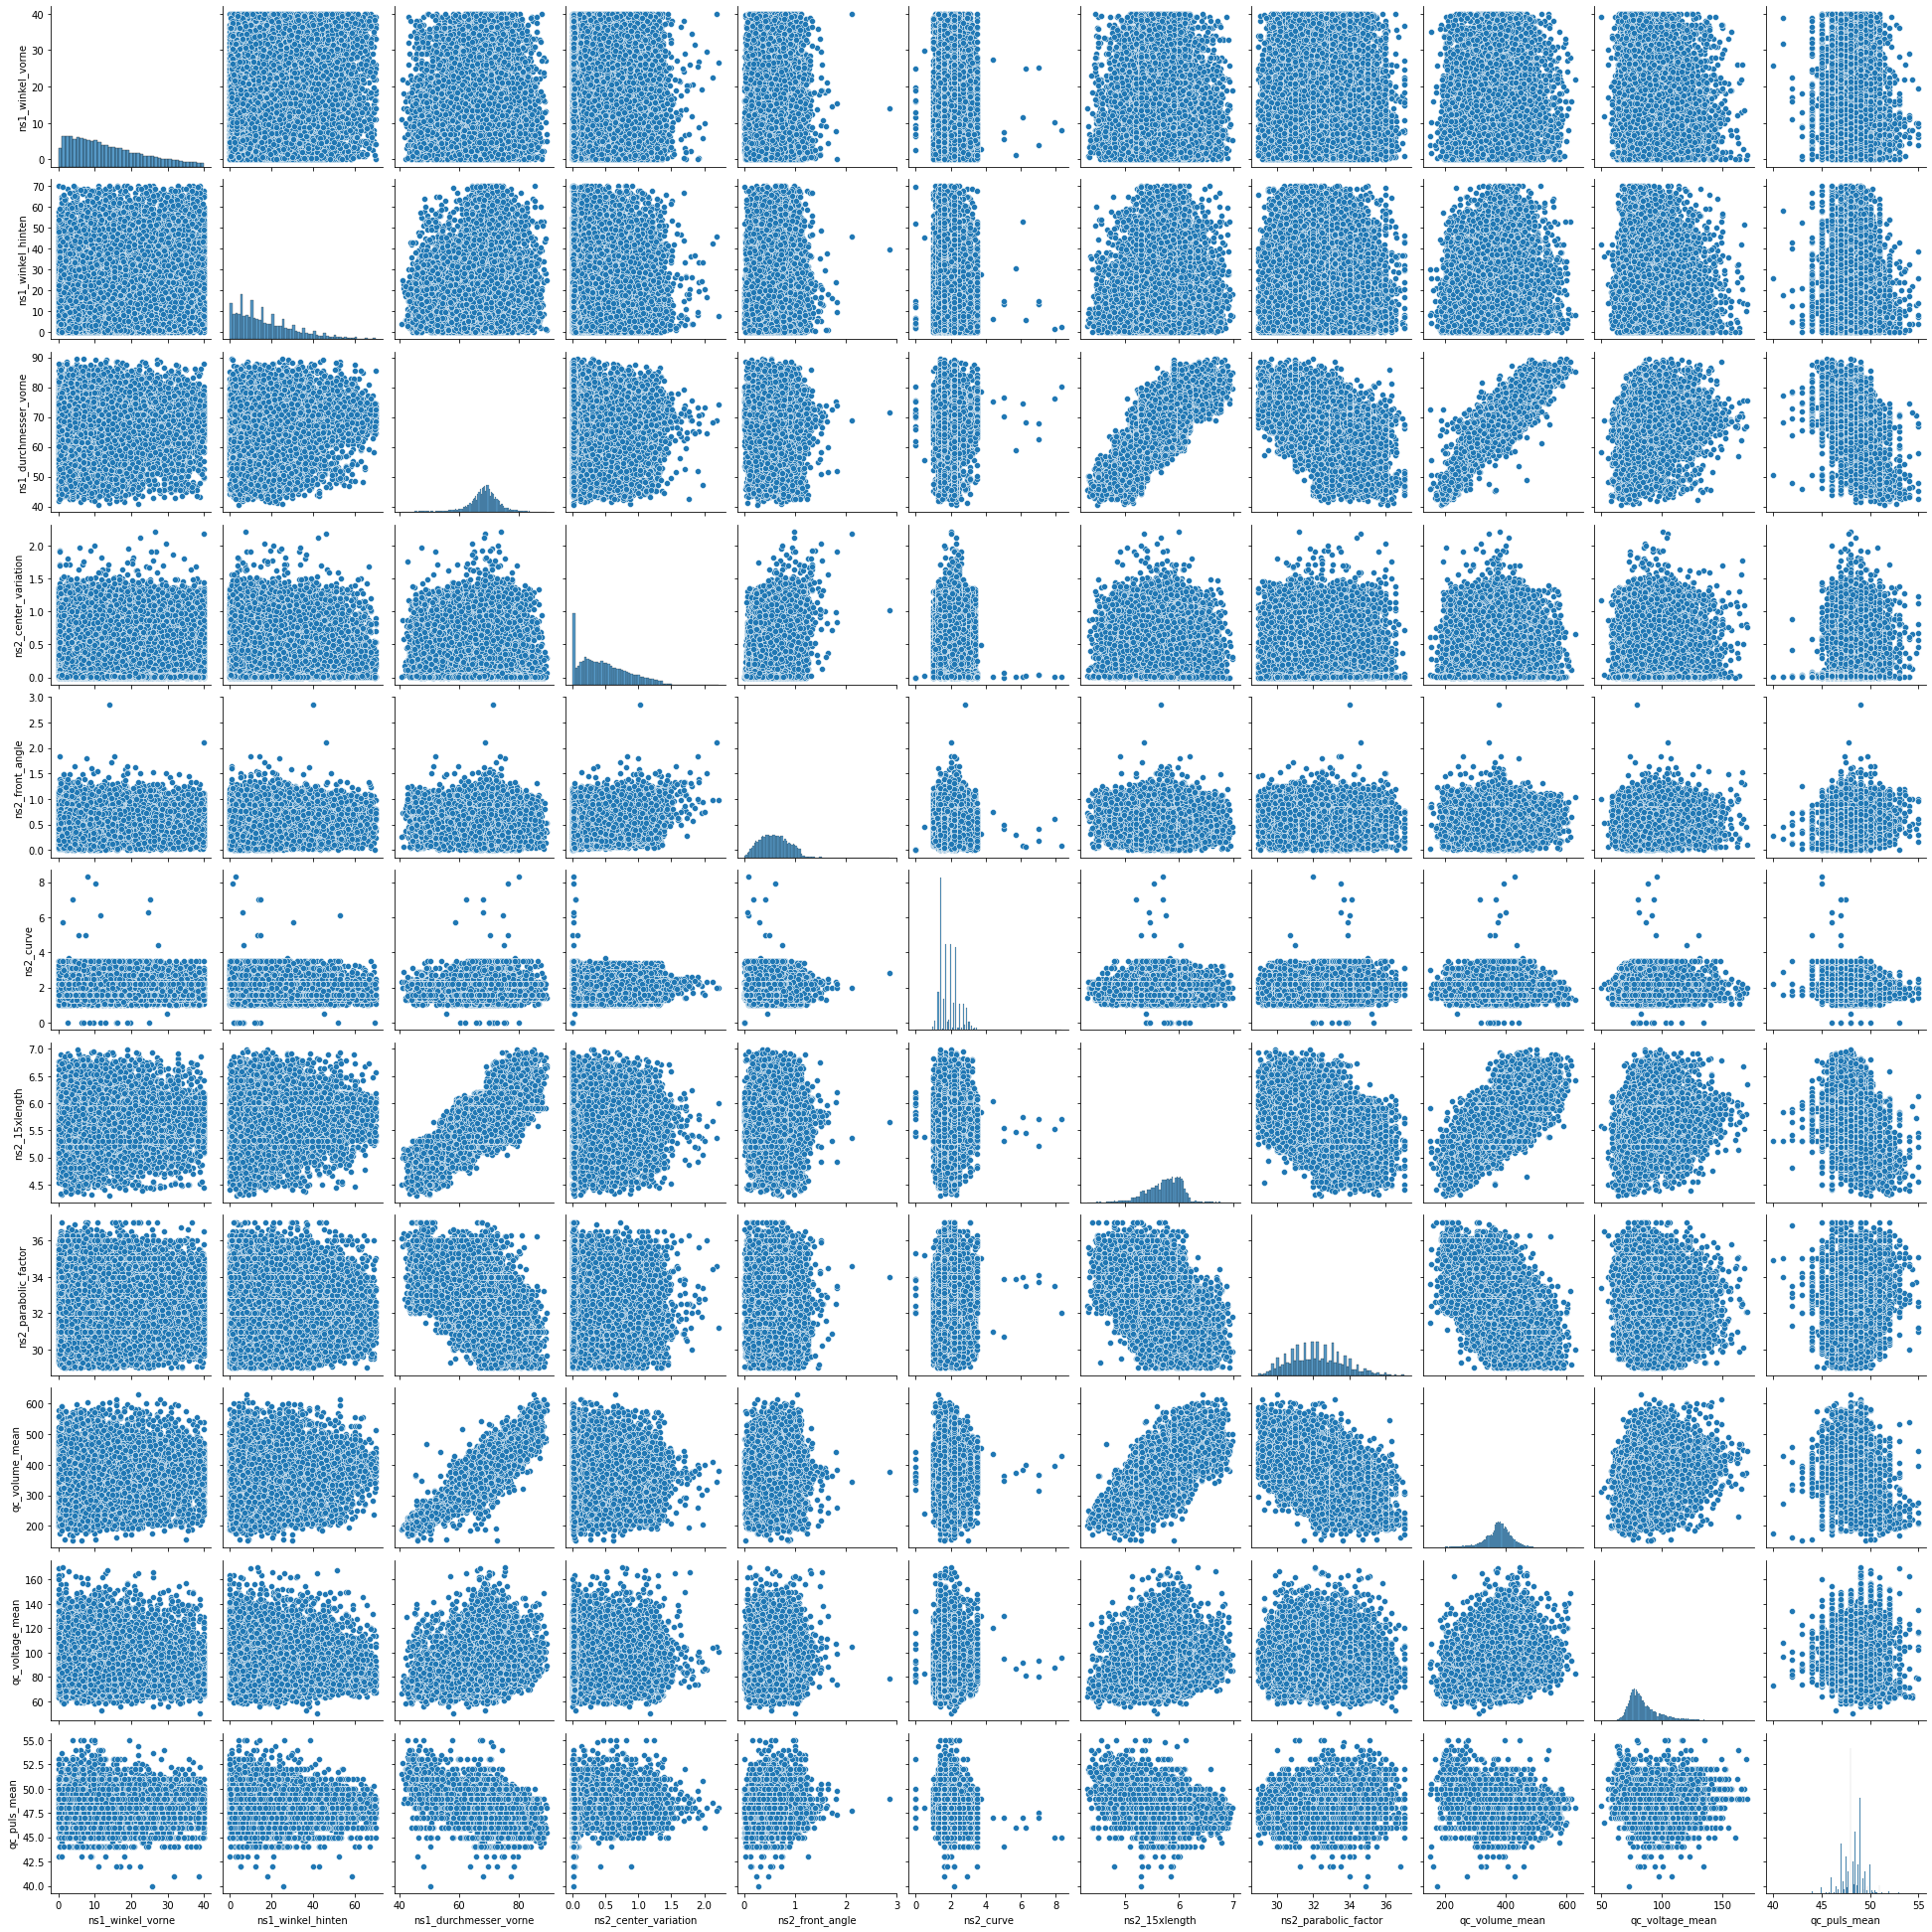

In [268]:
sns.pairplot(df_to_use)

In [253]:
X = df_to_use.drop('qc_volume_mean', axis=1)
y = df_to_use["qc_volume_mean"]

## Train - Test - Split

In [254]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2,random_state=81)

## Standardize the data after data split

In [255]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)
print("Coefficients: ", model.intercept_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(21810, 12) (5453, 12)
Coefficients:  [ 0.80825715  1.44278419 31.27699071  0.18087418 -1.5905228   0.30606476
 -5.43604258  1.0204934  -2.61502277 18.63838018  0.60770615 10.47723943]
Coefficients:  375.5661317438483


## Evaluating Model Performance

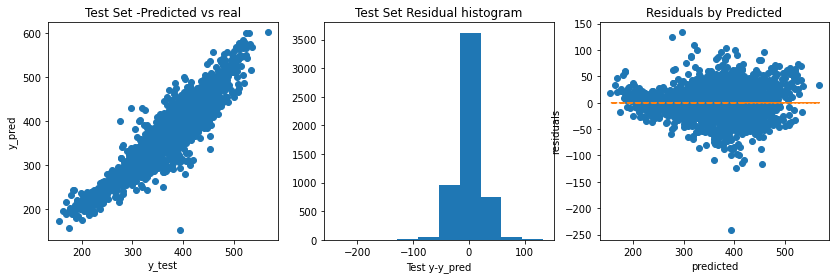

In [256]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

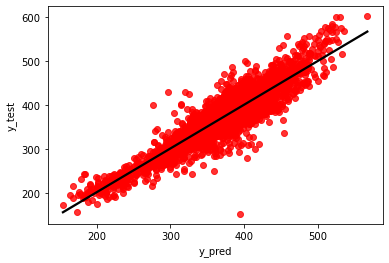

In [257]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

## Error metrics

In [258]:
mse_1 = round(mse(y_test,y_pred),2)
rmse_1 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_1 = round(mae(y_test,y_pred),2)

print("MSE:", mse_1) # shows squared error (harder to interpret)
print("MAE:", mae_1) # shows real error (in $)
print("-----")

# R^2
R2_1 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_1 = round(1 - (1-R2_1)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) only> is {round(R2_1,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) only> is {round(Adj_R2_1,2)}.")

MSE: 500.78
MAE: 16.65
-----
R^2 for <numerical (with outliers) only> is 0.82.
Adjusted R^2 for <numerical (with outliers) only> is 0.82.


**`OBSERVATIONS`**
- When not filtering on ns2_cv and ns2_fa, R2 increases from 0.72 to 0.82
- Changing random seed has significant impact (~ +/- 0.05) on R2

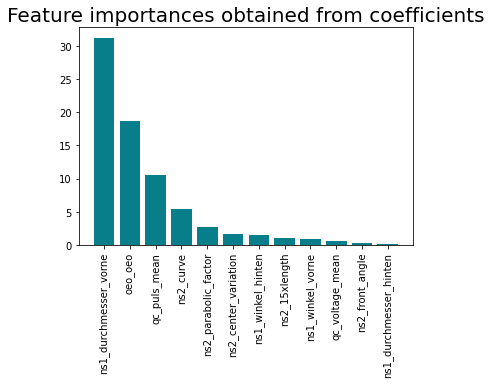

In [260]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False)

plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()